<h1 style="direction:rtl; padding-right:25px">
الگوریتم Forward-Forward
</h1>

<p style="direction:rtl; padding-right:25px">
۴۰۰۴۲۲۱۱۲
<br>
پروژه یادگیری ماشین
<br>
در این پروژه الگوریتم Fowrard-Forward بررسی می‌شود. این الگوریتم در مقاله‌ای به همین نام (۲۰۲۲) از جفری هینتون، از پدرخوانده‌های یادگیری عمیق معرفی شده است. این مقاله از 
<a href="https://www.cs.toronto.edu/~hinton/FFA13.pdf">اینجا</a>
 قابل دریافت است. مساله‌ مورد بحث، دسته‌بندی تصاویر یا Image Classification است.
</p>

<h2 style="direction:rtl; padding-right:25px">
توضیحات تئوری
</h2>

<h3 style="direction:rtl; padding-right:25px">
روش پایه‌ای: پس‌انتشار خطا (Backpropagation)
</h3>

<p style="direction:rtl; padding-right:25px">
در سال ۱۹۸۶، جفری هینتون (ایده‌پرداز الگوریتم forward-forward) یکی از مبدعان روش پس‌انتشار برای آموزش شبکه‌های عصبی بود. امروزه، بیشتر روش‌های مبتنی بر یادگیری عمیق از این روش برای آموزش استفاده می‌کنند. ابتدا داده‌ با رویکردی بالا به پایین فرآیند پیش‌رو (Forward Pass) را طی می‌کند. در انتها یک خروجی توسط شبکه تخمین زده می‌شود. سپس، با رویکردی پایین به بالا در فرآیند پس‌انتشار (Backpropagation)، مدل با مقایسه خروجی مدل و مقدار واقعی محاسبه می‌کند که هر پارامتر شبکه چقدر در بروز خطا نقش داشته است. این مهم، با محاسبه مشتقات جزیی تابع خطا نسبت به پارامترهای شبکه صورت می‌گیرد و گرادیان‌ها را با کمک قاعده مشتق زنجیره‌ای از لایه آخر به لایه‌های اول انتشار می‌دهد. سپس با استفاده از این گرادیان‌ها و الگوریتم‌های مبتنی بر گرادیان کاهشی، پارامترهای شبکه را در جهت کاهش خطا تغییر می‌دهیم تا زمانی که به یک کمینه محلی برای تابع خطا برسیم.
</p>

![forward-backward](./assets/forwad-vs-backward.png)

![forward-backward](./assets/chain-rule.png)

<h3 style="direction:rtl; padding-right:25px">
مشکل پس‌انتشار چیست؟
</h3>

<p style="direction:rtl; padding-right:25px">
همانطور که اشاره شد، امروزه انتخاب اول برای آموزش مدل‌های یادگیری عمیق استفاده از پس‌انتشار است. اما این روش با وجود کارکرد فوق‌العاده خود، محدودیت‌هایی نیز دارد. در نتیجه نیاز داریم روش‌های جدیدتری را جستجو و بررسی کنیم. از برخی از محدودیت‌های این روش می‌توان موارد زیر را نام برد:
<br><br>
این روش تفاوت بسیاری با آن چه از مغز می‌دانیم دارد. اتصالات بین نواحی مختلف در سیستم بینایی، با رویکرد پایین به بالای پس‌انتشار هم‌خوانی ندارد. در عوض، سیگنال‌های نورونی در حلقه‌هایی چندین لایه از قشر مغز را طی‌ کرده و سپس به مناطق قبلی باز می‌گردند.
<br><br>
جدا بودن فرآیند یادگیری (learning) از استنتاج (inference). به طور خاص، پس‌انتشار در طول زمان که به عنوان روشی برای یادگیری دنباله‌ها (seqence) استفاده می‌شود، غیرممکن است. برای تنظیم وزن یک شبکه عصبی، الگوریتم آموزشی باید استنتاج را متوقف کند تا پس‌انتشار انجام شود در صورتی که در دنیای واقعی، مغز یک جریان دائمی از اطلاعات را دریافت می‌کند.
<br><br>
اگر محاسبات انجام شده در فرآیند پیش‌رو مشتق‌پذیر نباشند یا یک black-box در طول مسیر وجود داشته باشد، استفاده از پس‌انتشار شدنی نیست.
<br><br>
در غیاب پس انتشار، می توانیم به یادگیری تقویتی (reinforcement learning) متوسل شویم. ایده این است که انحرافات (perturbation) تصادفی در وزن‌ها ایجاد کرده و آن‌ها را با تغییرات حاصل در یک تابع بازده مرتبط کنیم. با این حال، یادگیری تقویتی از واریانس بالایی رنج می‌برد. زمانی که چند متغیر را با هم تغییر دهیم، تعیین نتیجه تغییر یکی از آنها بر روی تابع بازده دشوار است. همچنین آموزش مدل RL هزینه بر است. پس چگونه بر چالش های ذکر شده غلبه کنیم؟
</p>

<h3 style="direction:rtl; padding-right:25px">
الگوریتم Forward-Forward
</h3>

<p style="direction:rtl; padding-right:25px">
به طور خلاصه، الگوریتم forward-forward یک فرآیند پیش‌رو (forward pass) و یک فرآیند پس‌انتشار را با دو فرآیند پیش‌رو تعویض می‌کند. این دو گذر مشابه هم هستند اما ۱) روی داده‌های متفاوتی صورت می‌گیرند و ۲) تابع هدف متضاد و متفاوتی دارند.
<br><br>
مزایا:‌ زمانی که جزییات دقیق محاسبات پیش‌رو ناشناخته باشد، می‌توان از این الگوریتم استفاده کرد. همچنین هنگام کار با داده‌های دنباله‌ای، بدون ذخیره‌سازی فعال‌سازهای نورونی (neural activities) می‌تواند به طور همزمان یادگیری و استنتاج را پیش‌ببرد. در ادامه، این روش در زمان‌هایی که سخت‌افزاری با قدرت پردازش بالا در دسترس نیست می‌تواند بهتر ظاهر شود.
<br><br>
معایب: در بسیاری از مسائل، از تعمیم‌پذیری خوبی برخوردار نیست به همین دلیل بعید است در مسایلی که محدودیت استفاده از انرژی نداریم، جایگزین پس‌انتشار شود.
</p>

<p style="direction:rtl; padding-right:25px">
این الگوریتم یک روش حریصانه است که در آن داده‌ها را به دو بخش مثبت و منفی تقسیم می‌کنیم و در دو گذر پیش‌رو به شبکه ورودی می‌دهیم. داده‌های منفی، داده‌هایی با برچسب غلط بوده و داده‌ها مثبت همان داده‌های اصلی هستند. داده‌های منفی را می‌توان به سادگی با انتخاب یک برچسب تصادفی غلط بدست آورد، همچنین از روش‌های مبتنی بر یادگیری می‌توان برای بدست آوردن آن‌ها نیز استفاده کرد. به جای تعریف یک تابع هزینه کلی برای کل شبکه، به ازای هر لایه یک معیار goodness تعریف می‌شود (یک دید local به جای global). در این مقاله، جمع مربعات خروجی‌های تابع فعالساز ReLU به عنوان معیار goodness استفاده شده است. حال هدف این است که وزن‌های هر لایه را به طوری تغییر دهیم که goodness روی داده‌های مثبت بیشتر از یک حد آستانه و goodness روی داده‌های منفی کمتر از آن آستانه باشد. خروجی‌های یک لایه قبل از گذار به لایه بعدی، نرمال‌ می‌شوند، در واقع برای هر لایه یک عملیات layer normalization صورت می‌گیرد. به طور خاص، هدف ما طبقه‌بندی صحیح بردارهای ورودی به عنوان داده‌های مثبت یا داده‌های منفی است با فرض اینکه احتمال مثبت بودن (واقعی بودن) یک بردار ورودی برابر است با:
</p>

$$p(positive)=\sigma (\sum_{j}^{}y_{j}^{2} - \theta )$$

<p style="direction:rtl; padding-right:25px">
که در آن yj خروجی فعال‌ساز نورون j قبل از نرمال‌سازی لایه است.
</p>

<h2 style="direction:rtl; padding-right:25px">
پیاده‌سازی کد
</h2>

In [1]:
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import random
from HodaDatasetReader import read_hoda_cdb, read_hoda_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.datasets import CIFAR10, MNIST
from utils.dataset_utils import TrainingDatasetFF
from utils.models import FFMultiLayerPerceptron, MultiLayerPerceptron
from utils.tools import base_loss, generate_positive_negative_samples_overlay
from torchvision.transforms import Compose, ToTensor, Lambda, Normalize

<p style="direction:rtl; padding-right:25px">
در ابتدا تابع تولید نمونه‌های مثبت و منفی را مشخص می‌کنیم. این تابع، برای تولید نمونه منفی، از یک برچسب غلط تصادفی استفاده می‌کند. همچنین از روشی تحت عنوان overlay برای جاگذاری برچسب استفاده می‌کند. بدین صورت که قسمتی کوچک به طول ۱۰ را از گوشه تصویر برای جاگذاری برچسب به صورت One-Hot کنار می‌گذارد.
</p>

In [2]:
pos_gen_fn = generate_positive_negative_samples_overlay

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

<h3 style="direction:rtl; padding-right:25px">
آماده‌سازی داده‌ها
</h3>


<p style="direction:rtl; padding-right:25px">
در این بخش به آماده‌سازی مجموعه داده مورد استفاده در این مساله می‌پردازیم. این مجموعه که شبیه مجموعه داده MNIST است، از اعداد دست‌نویس فارسی تشکیل شده است و مجموعه داده هدی نام دارد. این مجموعه شامل ۱۰۲ هزار نمونه بوده و اولین بار درسال ۲۰۰۵ در یک پایان‌نامه کارشناسی ارشد معرفی شده است. اطلاعات بیشتر درباره این مجموعه را از <a href="http://farsiocr.ir/%D9%85%D8%AC%D9%85%D9%88%D8%B9%D9%87-%D8%AF%D8%A7%D8%AF%D9%87/%D9%85%D8%AC%D9%85%D9%88%D8%B9%D9%87-%D8%A7%D8%B1%D9%82%D8%A7%D9%85-%D8%AF%D8%B3%D8%AA%D9%86%D9%88%DB%8C%D8%B3-%D9%87%D8%AF%DB%8C/">اینجا</a> بخوانید.
<br>
همانند مقاله الگوریتم Forward-Forward که نتایج آزمایشات خود را بر روی مجموعه داده MNIST گزارش می‌کند، تمامی پیاده‌سازی‌های آن در اینترنت نیز از همین مجموعه استفاده می‌کنند. به منظور ایجاد تمایز و بررسی یک مجموعه جدیدتر و بومی، این الگوریتم را روی مجموعه داده‌ هدی اجرا می‌کنم. لازم به ذکر است که بر خلاف MNIST که به سادگی از طریق بسته torch قابل دسترسی و استفاده است، کد اکثر مراحل بارگذاری و پیش‌پردازش مجموعه هدی برای torch به صورت دستی نوشته شده است.
</p> 

In [3]:
ax, ay = read_hoda_dataset(
    dataset_path="dataset/Train 60000.cdb",
    images_height=52,
    images_width=52,
    one_hot=True,
    reshape=False,
)

bx, by = read_hoda_dataset(
    dataset_path="dataset/Test 20000.cdb",
    images_height=52,
    images_width=52,
    one_hot=True,
    reshape=False,
)

cx, cy = read_hoda_dataset(
    dataset_path="dataset/RemainingSamples.cdb",
    images_height=52,
    images_width=52,
    one_hot=True,
    reshape=False,
)


<p style="direction:rtl; padding-right:25px">
همانطور که مشاهده می‌کنید، مجموعه شامل ۱۰۲ هزار تصویر سیاه و سفید با ابعاد ۵۲ در ۵۲ است.
</p>

In [4]:
X = np.concatenate((ax, bx, cx))
y = np.concatenate((ay, by, cy))
y_label = np.argmax(y, axis=1)
assert len(X) == len(y)
print(f"We have {len(X)} samples in total.")
print(f"sample shape: {X[0].shape}")

We have 102352 samples in total.
sample shape: (52, 52, 1)


<p style="direction:rtl; padding-right:25px">
تعدادی از نمونه‌های مجموعه داده را در این قسمت مشاهده می‌کنید.
</p>

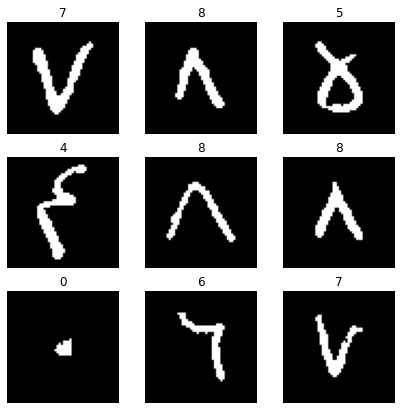

In [5]:
plt.figure(figsize=(7, 7))
smpl = random.sample(range(len(X)), 9)
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.axis("off")
    smpl_idx = smpl[i]
    plt.imshow(X[smpl_idx, :, :, 0], cmap="gray")
    plt.title(np.where(y[smpl_idx] == 1)[0][0])
plt.show()


<p style="direction:rtl; padding-right:25px">
این مجموعه دارای ۱۰ کلاس است. پس از بارگزاری آن، تمامی نمونه‌ها را با هم ادغام کرده، سپس برای حفظ تعادل در کلاس‌ها، از هر کلاس ۱۲٪ داده‌ها را برای test جدا کرده و بقیه را برای train در نظر می‌گیریم.
</p>

In [6]:
for cls in range(10):
    mask = np.where(y_label == cls)[0]
    X_cls = X[mask]
    y_cls = y_label[mask]
    (
        X_cls_train,
        X_cls_test,
        y_cls_train,
        y_cls_test,
    ) = train_test_split(
        X_cls, y_cls, test_size=0.12, random_state=42
    )
    if cls == 0:
        X_train = X_cls_train
        X_test = X_cls_test
        y_train = y_cls_train
        y_test = y_cls_test
        continue
    X_train = np.concatenate((X_train, X_cls_train), axis=0)
    X_test = np.concatenate((X_test, X_cls_test), axis=0)
    y_train = np.concatenate((y_train, y_cls_train), axis=0)
    y_test = np.concatenate((y_test, y_cls_test), axis=0)
print(
    f"train samples: {len(X_train)} | test samples: {len(X_test)}"
)


train samples: 90065 | test samples: 12287


In [7]:
class MyTensorDataset(Dataset):
    """TensorDataset with support of transforms."""

    def __init__(self, tensors, transform=None):
        assert all(
            tensors[0].size(0) == tensor.size(0)
            for tensor in tensors
        )
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


<p style="direction:rtl; padding-right:25px">
در این بخش تصاویر را flatten می‌کنیم، یعنی آن‌ها را از یک ماتریس دوبعدی به یک بردار تبدیل می‌کنیم. باید دقت کنیم که ابعاد تصویر ۵۲ در ۵۲ است، پس بردار حاصل شامل ۲۷۰۴ مقدار بوده و در نتیجه، لایه اول پرسپترون چندلایه ما باید شامل ۲۰۷۴ نورون باشد.
</p>

In [8]:
train_dataset = MyTensorDataset(
    (
        torch.Tensor(X_train),
        torch.Tensor(y_train).type(torch.LongTensor),
    ),
    transform=Lambda(lambda x: torch.flatten(x)),
)
test_dataset = MyTensorDataset(
    (
        torch.Tensor(X_test),
        torch.Tensor(y_test).type(torch.LongTensor),
    ),
    transform=Lambda(lambda x: torch.flatten(x)),
)

In [9]:
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

<p style="direction:rtl; padding-right:25px">
در این بخش یک دیتالودر خاص برای الگوریتم forward-forward می‌سازیم که با هربار فراخوانی، یک نمونه منفی و یک نمونه مثبت به دست می‌دهد.
</p>

In [10]:
def get_loader(dataset, batch_size=1024):
    train_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )

    train_loader_ff = DataLoader(
        TrainingDatasetFF(
            pos_gen_fn(X.to(device), Y.to(device), False)
            for X, Y in train_loader
        ),
        batch_size=train_loader.batch_size,
        shuffle=True,
    )
    return train_loader_ff

<h3 style="direction:rtl; padding-right:25px">
فرآیند آموزش
</h3>

<p style="direction:rtl; padding-right:25px">
ابتدا چند تابع کمکی تعریف می‌کنم. این کار برای کاهش خطوط کد نوشته شده و به کار گیری دوباره یک ماژول به ازای تنظیمات مختلف و مدل‌های مختلف است.
</p>

In [11]:
def do_train(train_loader, model, epochs):
    for epoch in tqdm(range(epochs)):
        for X_pos, Y_neg in train_loader:
            layer_losses = model.train_batch(
                X_pos, Y_neg, before=False
            )
            print(
                ", ".join(
                    map(
                        lambda i, l: f"Layer {i}: {l}",
                        list(range(len(layer_losses))),
                        layer_losses,
                    )
                ),
                end="\r",
            )


In [12]:
def do_test(test_dataloader, model):
    accuracy = 0
    counter = 0
    for X_test, Y_test in tqdm(test_dataloader, total=len(test_dataloader)):
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)

        accuracy += (
            model.predict_accomulate_goodness(
                X_test, pos_gen_fn, n_class=10
            )
            .eq(Y_test)
            .sum()
        )
        counter += len(X_test)

    print(f"Accuracy on test set: {accuracy/counter:.4%}")
    # print(f"Test error: {1 - accuracy/counter:.4%}")

<h4 style="direction:rtl; padding-right:25px">
آموزش و ارزیابی شبکه به روش Forward-Forward
</h4>

<p style="direction:rtl; padding-right:25px">
ابتدا یک شبکه به همراه دیتالودر تعریف کرده و کل لایه‌های آن را برای ۶۰ گام آموزش می‌دهیم.
</p>

In [13]:
train_loader_ff = get_loader(train_dataset, batch_size=1024)

In [14]:
mlp_model = FFMultiLayerPerceptron(
    hidden_dimensions=[2704, 512, 512],
    activation=torch.nn.ReLU(),
    optimizer=torch.optim.Adam,
    layer_optim_learning_rate=0.09,
    threshold=9.0,
    loss_fn=base_loss,
).to(device)

In [15]:
do_train(train_loader_ff, mlp_model, 60)

  0%|          | 0/60 [00:00<?, ?it/s]

In [16]:
do_test(test_loader, mlp_model)

  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy on test set: 97.8107%


<p style="direction:rtl; padding-right:25px">
حال مدل را برای گام‌های بیشتری آموزش می‌دهیم. به نظر می‌رسد اینکار تاثیری مثبتی بر دقت تست نداشته و باعث بروز بیش‌برازش می‌شود.
باید دقت داشت که به منظور مقایسه عادلانه، قبل از آموزش مدل با تنظیمات متفاوت و جدید باید پارامتر‌های آن را ریست کرد تا بهینه‌سازی را دوباره از وزن‌های تصادفی شروع کنیم، نه وزن‌هایی که قبلا مدل یاد گرفته است.
</p>

In [18]:
for layer in mlp_model.layers:
    layer.reset_parameters()
do_train(train_loader_ff, mlp_model, 200)

  0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
do_test(test_loader, mlp_model)

  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy on test set: 97.0945%


<p style="direction:rtl; padding-right:25px">
حال پیچدگی مدل را افزایش می‌دهیم. شاهد افزایش دقت تست هستیم.
</p>

In [19]:
mlp_model2 = FFMultiLayerPerceptron(
    hidden_dimensions=[2704, 1024, 1024],
    activation=torch.nn.ReLU(),
    optimizer=torch.optim.Adam,
    layer_optim_learning_rate=0.09,
    threshold=9.0,
    loss_fn=base_loss,
).to(device)

In [20]:
do_train(train_loader_ff, mlp_model2, 60)

  0%|          | 0/60 [00:00<?, ?it/s]

In [21]:
do_test(test_loader, mlp_model2)

  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy on test set: 98.0060%


<p style="direction:rtl; padding-right:25px;">
حال در هر لحظه، یک لایه را آموزش می‌دهیم. این کار به نظر تاثیر مثبتی بر دقت تست دارد و باعث افزایش آن می‌شود، اما دقت آن از مدلی پیچیده‌تر بیشتر نیست.
</p>

In [15]:
for layer in mlp_model.layers:
    layer.reset_parameters()
mlp_model.train_batch_progressive(60, train_loader_ff)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 60/60, Layer 0: 0.28755465149879456

Epoch: 60/60, Layer 1: 0.33019915223121643



In [16]:
do_test(test_loader, mlp_model)

  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy on test set: 97.9735%


<h4 style="direction:rtl; padding-right:25px">
آموزش و ارزیابی شبکه با پس‌انتشار خطا
</h4>

<p style="direction:rtl; padding-right:25px">
در این بخش، آموزش را با روش پس‌انتشار خطا یا Backpropagation انجام می‌دهیم. ابتدا توابع کمکی و دیتالودر را تعریف می‌کنیم.
</p>

In [17]:
train_loader = DataLoader(
    train_dataset, batch_size=1024, shuffle=True
)

In [26]:
loss_fn = torch.nn.CrossEntropyLoss()
n_epochs = 20

In [27]:
mlp_backprop_model = MultiLayerPerceptron(
    hidden_dimensions=[2704, 512, 512, 10],
    activation=torch.nn.ReLU(),
).to(device)
optimizer = torch.optim.Adam(mlp_backprop_model.parameters())

In [28]:
for epoch in tqdm(range(n_epochs)):
    for i, (X_train, Y_train) in enumerate(train_loader):
        X_train = X_train.to(device)
        Y_train = Y_train.to(device)

        Y_pred = mlp_backprop_model(X_train)

        loss = loss_fn(Y_pred, Y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss}", end="\r")


  0%|          | 0/20 [00:00<?, ?it/s]

In [32]:
accuracy = 0
counter = 0

for X_test, Y_test in tqdm(test_loader, total=len(test_loader)):
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    counter += len(X_test)
    accuracy += (
        torch.softmax(mlp_backprop_model(X_test), 1)
        .argmax(1)
        .eq(Y_test)
        .sum()
    )

print(f"Accuracy: {accuracy/counter:.4%}")
print(f"Test error: {1 - accuracy/counter:.4%}")


  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy: 98.7141%
Test error: 1.2859%


<p style="direction:rtl; padding-right:25px">
همانطور که مشخص است، آموزش مدل با پس‌انتشار خطا، در گام‌های کمتر به خطای بسیار کوچکتری روی داده‌های آموزشی می‌رسد، همچنین دقت تست بیشتری نیز دارد. در نتیجه به نظر بعید است که الگوریتم forward-forward در کارکردهای معمولی جایگزین پس‌انتشار خطا شود.
</p>